# LncRNA classification with an RNA language model
This example notebook shows the basic functionalities of the `lncrnapy`
package and how it can be used to train an RNA language model for lncRNA 
classification, i.e. detecting whether a novel transcript is coding or long
non-coding. Full documentation is provided 
[here](https://luukromeijn.github.io/lncRNA-Py). 

In this notebook, we shall cover both the 
[feature-based](#feature-based-classification) and 
[sequence-based](#sequence-based-classification-lncrna-bert) 
(lncRNA-BERT) approach to lncRNA classification. Both approaches
make use of the same `Data` class, which shall be explained first.

## Data
Let us start by loading some sequence data. The `Data` class can hold sequence
data and is designed to work with predictor feature extractors as well as deep
learning methods. Under the hood, its most important attribute is `df`, which is
a `pandas.DataFrame` object.

At initialization, `Data` accepts either a single FASTA file (for unlabelled 
data), a list of two FASTA files (for pcRNA and lncRNA, respectively), or an
HDF file (for additional data columns). Data can also be exported to FASTA or 
the highly efficient HDF format using the `.to_fasta` or `.to_hdf` methods.

We load some data, generate a train/test split, and save the test set for later
use.

In [1]:
from lncrnapy.data import Data

data_dir = 'data' # Change this for your setup

data = Data([f'{data_dir}/sequences/gencode.v46.pc_transcripts.fa',
             f'{data_dir}/sequences/gencode.v46.lncRNA_transcripts.fa'])
train, test = data.train_test_split(test_size=0.2)
test.to_fasta('gencode.v46.test.fasta')

print(train)

c:\Users\luukr\miniconda3\envs\lncrna\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Importing data...
Imported 111868 protein-coding and 59927 non-coding RNA transcripts with 0 feature(s).
                                                       id  \
121698  ENST00000627043.2|ENSG00000236445.5|OTTHUMG000...   
166000  ENST00000596379.1|ENSG00000268307.1|OTTHUMG000...   
4962    ENST00000459635.2|ENSG00000162650.17|OTTHUMG00...   
1165    ENST00000714038.1|ENSG00000117118.12|OTTHUMG00...   
34897   ENST00000415099.2|ENSG00000213760.11|OTTHUMG00...   
...                                                   ...   
71846   ENST00000493471.2|ENSG00000100804.19|OTTHUMG00...   
121818  ENST00000415628.1|ENSG00000232520.2|OTTHUMG000...   
74448   ENST00000435962.7|ENSG00000165929.13|OTTHUMG00...   
132150  ENST00000675225.1|ENSG00000288612.1|-|-|ENST00...   
3172    ENST00000351829.9|ENSG00000117448.14|OTTHUMG00...   

                                                 sequence  label  
121698  AGTGGCATCATTGCACTGTGACTGTGCAGGTCCCAAACAGTATGGA...  ncRNA  
166000  CCAGCTCGCTCCTAGGTGCT

## Feature-Based Classification
Now that we have loaded our data, we can calculate some features using 
`lncrnapy`'s large feature library. Hereto, we use the `calculate_feature` 
method of a `Data` object. 

Let's say we are interested in the Fickett score, the transcript length, and the
length of the Open Reading Frame (ORF). We then need the following feature
extractor classes from the `features` module:
 - `FickettScore`: Calculates the Fickett score 
 ([Fickett et al., 1982](https://doi.org/10.1093/nar/10.17.5303)) using a 
 reference file based on the original paper.
 - `Length`: Calculates the length of the transcript.
 - `ORFCoordinates`: Identifies the longest ORF in the sequence.
 - `ORFLength`: Calculates the ORF length, assuming that have already calculated
 the ORF coordinates.

In [2]:
from lncrnapy.features import FickettScore, Length, ORFCoordinates, ORFLength

fickett = FickettScore(f'{data_dir}/features/fickett_paper.txt')
length = Length()
orf_coords = ORFCoordinates()
orf_length = ORFLength()

for dataset in [train, test]:
    for feature_extractor in [fickett, length, orf_coords, orf_length]:
        dataset.calculate_feature(feature_extractor)

Calculating Fickett TESTCODE...


137436it [01:35, 1435.42it/s]


Finding Open Reading Frames...


137436it [03:05, 741.21it/s]


Calculating Fickett TESTCODE...


34359it [00:23, 1463.90it/s]


Finding Open Reading Frames...


34359it [00:52, 660.37it/s]


Now let us plot some of the results. Feature extractor classes sometimes extract
multiple features (e.g. `ORFCoordinates` identifies both 'ORF (start)' and 
'ORF (end)'). To know the name of these features, we can simply use the `.name`
attribute.

Fickett score


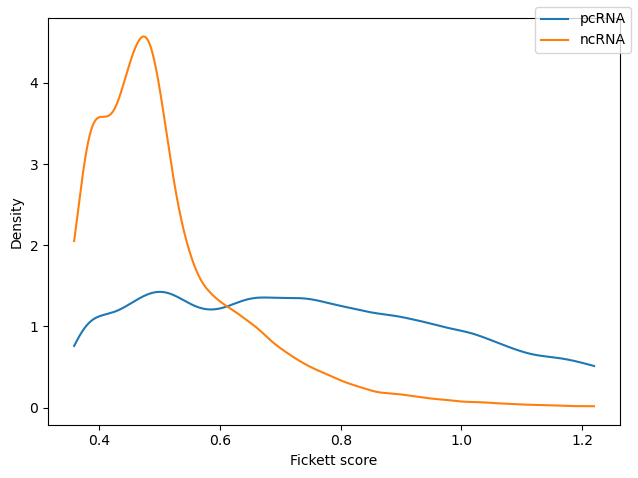

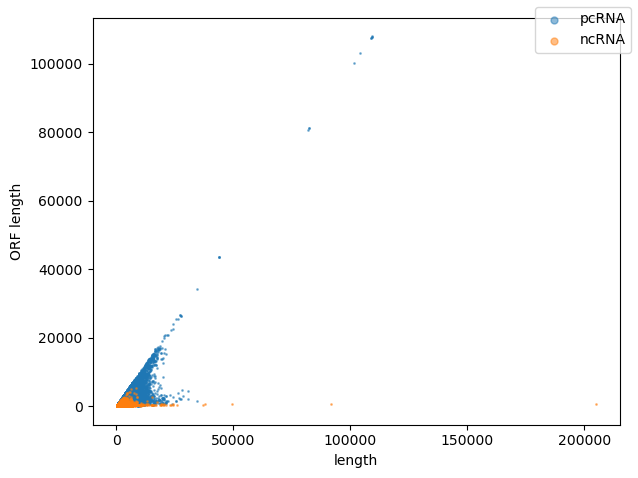

In [3]:
train.plot_feature_density(fickett.name)
train.plot_feature_scatter('length', 'ORF length')
print(fickett.name)

That last plot indicates that there are some extremely long sequences in the
dataset. Let's assume that we want to filter out those sequences for training 
and then recreate the plot. 

# Remaining transcripts: 136209


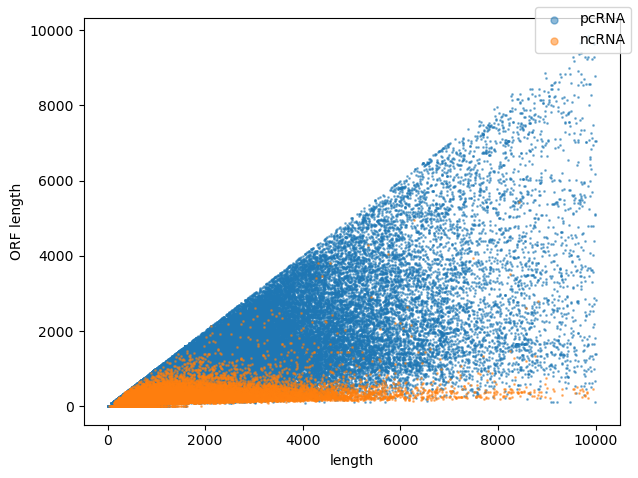

In [4]:
train.filter_outliers('length', [0,10000])
train.plot_feature_scatter('length', 'ORF length')
print("# Remaining transcripts:", len(train))


The plots show that the features are informative for distinguishing coding from 
non-coding RNA. Now let's define a simple logistic regression classifier using 
the features we've just calculated.

In [7]:
from lncrnapy.algorithms import Algorithm
from sklearn.linear_model import LogisticRegression
from lncrnapy.evaluate import lncRNA_classification_report

feature_based_model = Algorithm(
    model=LogisticRegression(),
    feature_extractors=[fickett, length, orf_coords, orf_length],
    used_features=['Fickett score', 'length', 'ORF length']
)

feature_based_model.fit(train)
prediction = feature_based_model.predict(test)
print(lncRNA_classification_report(test.df['label'], prediction, 
                                   'Logistic Regression', 'Test'))

c:\Users\luukr\Documents\Programming_assignments\MSc\rhythmnblues\lncrnapy\algorithms\algorithm.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data.df['label'].replace({'pcRNA':1, 'ncRNA':0})


                Method Dataset  Accuracy  Precision (pcRNA)  \
0  Logistic Regression    Test   0.85733           0.907553   

   Precision (ncRNA)  Precision (weighted)  Precision (macro)  Recall (pcRNA)  \
0           0.774987              0.861018            0.84127        0.868643   

   Recall (ncRNA)  Recall (weighted)  Recall (macro)  F1 (pcRNA)  F1 (ncRNA)  \
0        0.836415            0.85733        0.852529    0.887672     0.80453   

   F1 (weighted)  F1 (macro)  
0       0.858487    0.846101  


Great! We already obtain a macro-averaged F1 score of 0.85 using a very simple
model and only three features.

## Sequence-Based Classification (lncRNA-BERT)
Now let's train a more advanced model. In this section, we shall pre-train and 
fine-tune a Nucleotide Language Model, like lncRNA-BERT. 

### Encoding
We must first encode the data into a numeric Tensor format that is compatible 
with the BERT model that we wish to use. The `lncrnapy` package supports four
encoding methods: 
- Nucleotide-Level Tokenization (NUC): every nucleotide is a token. 
- K-mer Tokenization (K-mer): every k-mer is a token. 
- Byte Pair Encoding (BPE): fixed-size vocabulary of variable-length tokens, 
based on their occurrence frequency. 
- Convolutional Sequence Encoding (CSE): directly embed a k-mer into a high-
dimensional representation by using a 1D convolution.

In [2]:
pretrain_data.set_tensor_features('4D-DNA')

To illustrate what we just did, let us sample a sequence by indexing.

In [3]:
sequence, label = pretrain_data[0] # Sample the first sequence
print("Sequence:")
print(sequence)
print("Label (0=ncRNA, 1=pcRNA):")
print(label)

Sequence:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
Label (0=ncRNA, 1=pcRNA):
tensor([1.], device='cuda:0')


### Neural architecture
Now we can define a model. The most important component of our model is its 
base architecture. `lncrnapy.modules` contains several types of
architectures implementations, including CNNs (e.g. `ResNet`) and language 
models (e.g. `BERT`). Convolutional Sequence Encoding requires a special variant of BERT, which 
is implemented in the `CSEBERT` class.

In [4]:
from lncrnapy.modules import CSEBERT
base_arch = CSEBERT(n_kernels=768, kernel_size=9) 

`lncrnapy.modules` also contains several wrapper classes that encapsulate a
base architecture and add the required layers to perform tasks like 
classification, regression, and masked language modeling. For example, this is
how we turn our model into a classifier: 

In [ ]:
from lncrnapy.modules import Classifier
from lncrnapy import utils

model = Classifier(base_arch)
model = model.to(utils.DEVICE) # Send the model to the GPU.

Now let's make a prediction on the validation dataset. 

In [6]:
# Load and encode the data
valid_data = Data([f'{data_dir}/sequences/valid_gencode_pcrna.fasta',
                   f'{data_dir}/sequences/valid_gencode_ncrna.fasta'])
valid_data.set_tensor_features('4D-DNA')

# Make a prediction
prediction = model.predict(valid_data)
print(prediction)

Importing data...
Imported 5583 protein-coding and 2998 non-coding RNA transcripts with 0 feature(s).


tensor([[0.4755],
        [0.4519],
        [0.4753],
        ...,
        [0.4651],
        [0.4455],
        [0.4553]])


### Pre-training
The prediction made above is only a random one, as we have not trained our model
yet. Language models are often pre-trained before being fine-tuned to perform 
a specific task. We shall do the same. 

First, we must wrap the base architecture into the proper wrapper class:

In [7]:
from lncrnapy.modules import MaskedConvModel

model = MaskedConvModel(base_arch).to(utils.DEVICE)

Now we can train it using the `train_masked_conv_modeling` function.

In [ ]:
from lncrnapy.train import train_masked_conv_modeling

model, history = train_masked_conv_modeling(
    model, pretrain_data, valid_data, epochs=500
)

print(history) # Contains the performance at every epoch

### Fine-tuning
After pre-training, we can extract the base architecture and wrap it inside a
`Classifier` object again. We can then fine-tune our model using the 
`train_classifier` function.

In [ ]:
from lncrnapy.train import train_classifier

finetune_data = Data([f'{data_dir}/sequences/finetune_gencode_pcrna.fasta',
                      f'{data_dir}/sequences/finetune_gencode_ncrna.fasta'])

model = Classifier(model.base_arch).to(utils.DEVICE)
model, history = train_classifier(model, pretrain_data, valid_data, epochs=100)

print(history)